In [1]:
import pandas as pd
from os import listdir
from pandas.errors import EmptyDataError
from unidecode import unidecode
import seaborn as sns
import re
from wordcloud import WordCloud
from gensim.models import Word2Vec
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import numpy as np
from scipy.spatial import distance

sns.set(
    rc = {
        'figure.figsize': (10, 8)
    },
    style = 'darkgrid'
)

In [2]:
 df = pd.concat([
    pd.read_csv('data/concatenated/'+filename)
    for filename in
    listdir('data/concatenated')
])

# Dictionares

In [3]:
grouping_orders = {
    "website": {
        "columns_before": ['website', 'sentiment'],
        "groupby": ["website"],
        "columns_after": ['fakt', 'gazeta', 'wyborcza'] 
    },
    "brand": {
        "columns_before": ['brand', 'sentiment'],
        "groupby": ["brand"],
        "columns_after": ['agora', 'ringier'] 
    },
    "country": {
        "columns_before": ['country', 'sentiment'],
        "groupby": ["country"],
        "columns_after": ['de/ch', 'pl'] 
    }
}

In [4]:
brand_keys = {
    "pl": {
        "agora": ['wyborcza', 'gazeta']
    },
    "de/ch": {
        "ringier": ['fakt', 'onet', 'newsweek']
    },
    'us': {
        "discovery": ['tvn']
    }
}

In [5]:
osoba = ['ideał', 'wróg'] # wzór, wróg, nieprzyjaciel
partia = ['postęp', 'zacofanie'] # rozwój, dobrobyt, 
poglad = ['swoboda', 'reżim'] # chaos, totalitaryzm, racjonalizm
kraj = ['sojusznik', 'wróg'] # ostoja, oaza, 
keyword_reference_words = {
    'sąd': ['sprawiedliwość', 'niesprawiedliwość'],
    'imigranci': ['przyjaciele', 'wrogowie'],
    'ekologia': ['', ''],
    'emigracja': ['szansa', 'ucieczka'], # szansa
    'pis': partia,
    'platforma': partia,
    'duda': osoba,
    'morawiecki': osoba,
    'szydło': osoba,
    'kaczyński': osoba,
    'kwaśniewski': osoba,
    'lewica': poglad,
    'prawica': poglad,
    'lgbt': ['tolerancja', ''],
    'europa': ['wspólnota', 'podział'], # rozłam
    'rosja': kraj,
    'stany': kraj,
    'premier': osoba,
    'prezydent': osoba,
    'opozycja': partia,
    'rząd': partia,
    'sejm': partia,
    'polska': ['oaza', ''],
    'putin': ['sojusznik', 'wróg'],
    'trump': ['sojusznik', 'wróg'],
    'ukraina': kraj,
    'media': ['', ''],
    'bank': ['bezpieczeństwo', 'wyzysk'],
    'niemcy': kraj,
    'papież': osoba,
    'kościół': ['oparcie', 'firma'],
    'korwin': osoba,
    'rydzyk': osoba,
    'feminizm': ['równość', 'patriarchat'],
    'leszek+miller': osoba,
}

In [6]:
decoder = {
    '%B1': 'ą',
    '%BF': 'ż',
    '%B3': 'ł',
    '%B6': 'ś',
    '%F1': 'ń',
    '%F3': 'ó'
}
with open('keywords', 'r') as f:
    raws = f.read().split('\n')
keyword_dict = {}
for raw in raws:
    tmp_keyword = raw
    for d1, d2 in decoder.items():
        tmp_keyword = tmp_keyword.replace(d1, d2)
    keyword_dict[tmp_keyword] = ''

In [7]:
keyword_regex = {
    'pis': r"\Dpis\D|prawo i sprawiedliwość"
}

# Analyze

## Get emotions data from polish wordnet

In [22]:
# http://plwordnet.pwr.wroc.pl//wordnet/download-wordnet?key=1iflsj&file=4.0
# extract one file (słownik_anotacji_emocjonlanej) to home directory

In [23]:
emotions = pd.read_csv('~/słownik_anotacji_emocjonlanej.csv')[['lemat', 'emocje']].dropna()

In [24]:
emotions.head()

,lemat,emocje
2,abstrakcyjny,wstręt;złość;zaskoczenie
3,abstrakcyjny,wstręt;złość
10,adorator,złość;radość
11,adorator,złość;cieszenie się na;radość;wstręt
18,afektowany,złość;smutek


In [25]:
emotions['emocje'] = emotions['emocje'].str.replace(':', ';')

In [26]:
pairs = [
    ('złosć', 'negatywny'),
    ('zlość', 'negatywny'),
    ('złośc', 'negatywny'),
    ('złość wstręt', 'negatywny'),
    ('złość: nieużyteczność', 'negatywny'),
    ('złóść', 'negatywny'),
    ('bład', 'negatywny'),
    ('brzydota', 'negatywny'),
    ('błąd', 'negatywny'),
    ('gniew', 'negatywny'),
    ('krzywda', 'negatywny'),
    ('nieszczęscie', 'negatywny'),
    ('nieszczęście', 'negatywny'),
    ('nieużyteczność', 'negatywny'),
    ('złość', 'negatywny'),
    ('strach', 'negatywny'),
    ('strach wstręt', 'negatywny'),
    ('smute', 'negatywny'),
    ('smutek', 'negatywny'),
    ('wstęt', 'negatywny'),
    ('niewiedza', 'negatywny'),
    ('negatywny wstręt', 'negatywny'),
    ('negatywnyk', 'negatywny'),
    ('negatywnyk: negatywny', 'negatywny'),
    ('wstrę', 'negatywny'),
    ('wstręt', 'negatywny'),
    ('wstręt: negatywny', 'negatywny'),
    ('negatywnyt', 'negatywny'),
    ('s mutek', 'negatywny'),
    ('wstret', 'negatywny'),
    ('smitek', 'negatywny'),
    (' negatywny', 'negatywny'),
    
    ('cieszenie sie', 'pozytywny'),
    ('cieszenie sie na', 'pozytywny'),
    ('cieszenie się na coś oczekiwanego', 'pozytywny'),
    ('dobro', 'pozytywny'),
    ('cieszenie sie', 'pozytywny'),
    ('radoć', 'pozytywny'),
    ('radość', 'pozytywny'),
    ('radość: piękno', 'pozytywny'),
    ('radość: szczęście', 'pozytywny'),
    ('zaufanie', 'pozytywny'),
    ('cieszenie się', 'pozytywny'),
    ('cieszenie się na', 'pozytywny'),
    ('ciesznie się na', 'pozytywny'),
    ('piękno', 'pozytywny'),
    ('pozytywny: piękno', 'pozytywny'),
    ('pozytywny: szczęście', 'pozytywny'),
    ('prawda', 'pozytywny'),
    ('radosć', 'pozytywny'),
    ('pozytywny: pozytywny', 'pozytywny'),
    ('radośc', 'pozytywny'),
    ('szczęście', 'pozytywny'),
    ('użyteczność', 'pozytywny'),
    ('wiedza', 'pozytywny'),
    ('zufanie', 'pozytywny'),
    ('pozytywny na', 'pozytywny'),
    (' pozytywny', 'pozytywny'),
    
    ('zaskoczenie czymś nieprzewidywanym', ''),
    ('oczekiwanie na', ''),
    (' czymś nieprzewidywanym', ''),
    ('-', ''),
    ('zaskoczenie', ''),
    ('pozytywnynegatywny', ''),
]

In [27]:
for pair in pairs:
    emotions['emocje'] = emotions['emocje'].str.replace(pair[0], pair[1])

In [28]:
emotions = pd.concat([
    emotions['lemat'],
    emotions['emocje']\
        .str.get_dummies(sep = ';')\
], axis = 1)

In [29]:
emotions.loc[
    emotions['pozytywny'] == emotions['negatywny']
, 'ambiguous'] = True

In [30]:
len(emotions)

56420

In [31]:
emotions = emotions[emotions['ambiguous'].isna()]
emotions = emotions.drop('ambiguous', axis = 1)

In [32]:
len(emotions)

47477

In [33]:
emotions['negatywny'].sum()

31505

In [34]:
emotions['pozytywny'].sum()

15972

In [35]:
emotions.sample(5).head()

,lemat,negatywny,pozytywny
107694,nieskwapliwość,0,1
154808,spokojniuchny,0,1
109344,subtelność,0,1
74825,uznaniowy,1,0
155569,kombinacyjnie,0,1


In [36]:
emotions = emotions.drop('negatywny', axis = 1)

In [37]:
emotions.loc[emotions['pozytywny'] == 0, 'pozytywny'] = -1

In [38]:
emotions.columns = ['lemat', 'sentyment']

In [39]:
emotions = emotions.drop_duplicates()

In [40]:
emotions.sample(5).head()

,lemat,sentyment
68449,letargiczny,-1
8470,wytłumaczyć,1
45315,człowiek wielkiego ducha,1
168779,fetyszystyczny,-1
27600,unifikator,1


In [41]:
emotions_dict = {x[0]:x[1] for x in emotions.values}

## Titles/shorts

In [42]:
emotions.sample(5).head()

,lemat,sentyment
161843,pośpieszyć,1
8634,zadra,-1
84046,niezły,1
131006,marzenie ściętej głowy,-1
44288,panienka spod latarni,-1


In [43]:
emotion_words = emotions_dict.keys()

In [44]:
df['sentiment'] = df['long'].str.lower().apply(lambda x: sum([emotions_dict[a] 
                                         for a in str(x).split(' ')
                                         if a in emotion_words]))

In [45]:
grouped_data = {}
for key, grouping_order in grouping_orders.items():
    data_dict = {}
    for keyword in keywords:
        data_dict[keyword] = df\
            [(df[keyword] == 1)&(df['sentiment'] != 0)]\
            [grouping_order['columns_before']]\
            .groupby(grouping_order['groupby'])\
            .mean()\
            .values\
            .flatten()
    res = pd.DataFrame().from_dict(
        data_dict,
        'index',
        columns = grouping_order['columns_after']
    )
    res = (res - res.mean())/res.std()
    grouped_data[key] = res

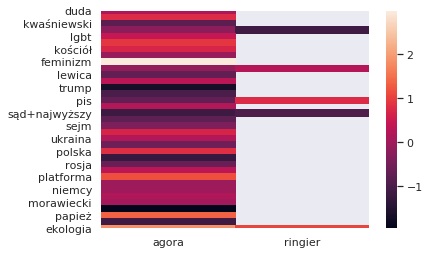

In [46]:
sns.heatmap(grouped_data['brand']);

In [47]:
# compare that chart (two websites in one company), and two websites from two different companies

## Regex

In [48]:
wc = WordCloud()

In [49]:
keyword_patterns = ['duda', 'dudy', 'dude']

In [50]:
found_records = df[['long']][
    df['long'].str.lower().str.contains(r'|'.join(keyword_patterns)) == True
].values.flatten()

In [51]:
keyword_words_before = []
keyword_words_after = []
for record in found_records:
    tmp_string_list = re.sub(r'\W+', ' ', record).lower().split(' ')
    keyword_idxs = [n for n, x in enumerate(tmp_string_list) if x in keyword_patterns]
    max_idx = len(tmp_string_list)
    for keyword_idx in keyword_idxs:
        if keyword_idx < max_idx - 2 and keyword_idx > 1:
            keyword_context_before = tmp_string_list[keyword_idx-2 : keyword_idx]
            keyword_words_before.append(keyword_context_before[0])
            keyword_words_before.append(keyword_context_before[1])
            keyword_context_after = tmp_string_list[keyword_idx+1 : keyword_idx+3]
            keyword_words_after.append(keyword_context_after[0])
            keyword_words_after.append(keyword_context_after[1])

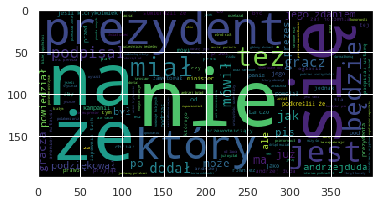

In [52]:
plt.imshow(wc.generate(" ".join(keyword_words_after)))

## Word2Vec

In [8]:
df['whole_string'] = (
    df['title'] + '. ' +
    df['short'] + '. ' +
    df['long']
)

In [9]:
def make_sentences(df):
    sentences = []
    for record in df['whole_string'].dropna().str.lower():
        if record != None:
            for sentence in record.split('.'):
                sentences.append(re.sub(r'\W+', ' ', sentence).lower().strip().split(' '))
    return sentences

In [38]:
models = {}
models['model'] = Word2Vec(make_sentences(df), min_count = 10, window = 5, workers = 10)
for country, brand_dict in brand_keys.items():
    models[country] = {}
    for brand_name in df['brand'].unique():
        models[country][brand_name] = {}
        brand_data = make_sentences(df[df['brand'] == brand_name])
        models[country][brand_name]['model'] = Word2Vec(brand_data, min_count = 10, window = 5, workers = 10)

In [12]:
models = {}
models['model'] = Word2Vec(make_sentences(df), min_count = 10, window = 5, workers = 10)

KeyboardInterrupt: 

In [64]:
model_dict_keys = (
    ('us', 'discovery'),
    ('pl', 'agora'),
    ('de/ch', 'ringier')
)
results = []
df_idx = []
for keyword, reference in keyword_reference_words.items():
    if '' not in reference and '+' not in keyword:
        row = []
        for model_dict_key in model_dict_keys:
            #positive_dist = models[model_dict_key[0]][model_dict_key[1]]['model'].wv.distance(keyword, reference[0])
            #negative_dist = models[model_dict_key[0]][model_dict_key[1]]['model'].wv.distance(keyword, reference[1])
            keyword_vector = models[model_dict_key[0]][model_dict_key[1]]['model'].wv[keyword]
            positive_vector = models['model'].wv[reference[0]]
            negative_vector = models['model'].wv[reference[1]]
            positive_dist = distance.euclidean(keyword_vector, positive_vector)
            negative_dist = distance.euclidean(keyword_vector, negative_vector)
            score = negative_dist / (negative_dist + positive_dist)
            row.append(score)
        results.append(row)
        df_idx.append(keyword)

In [65]:
vector_results = pd.DataFrame(results, columns = ['discovery', 'agora', 'ringier'], index = df_idx)

In [66]:
vector_results

,discovery,agora,ringier
sąd,0.439091,0.440355,0.395756
imigranci,0.348054,0.295555,0.367978
emigracja,0.283273,0.286020,0.295115
pis,0.479461,0.465140,0.493849
platforma,0.453502,0.437810,0.423341
duda,0.533978,0.529102,0.525422
morawiecki,0.538739,0.531837,0.520788
szydło,0.522916,0.535837,0.518871
kaczyński,0.510792,0.512393,0.525279
kwaśniewski,0.513442,0.555287,0.553764


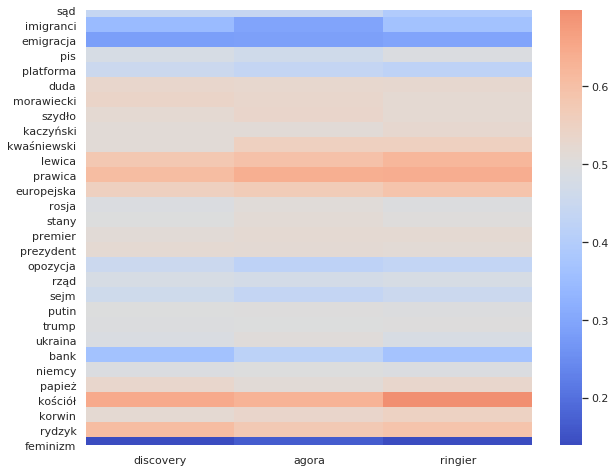

In [67]:
sns.heatmap(vector_results, cmap = 'coolwarm', center = 0.5)

In [49]:
models['model'].wv.most_similar('polska')

[('europa', 0.793864905834198),
 ('ukraina', 0.6964738965034485),
 ('grecja', 0.6921900510787964),
 ('rosja', 0.6876075863838196),
 ('nasza', 0.6589422821998596),
 ('francja', 0.6476138830184937),
 ('ameryka', 0.6435331702232361),
 ('turcja', 0.6369907855987549),
 ('gruzja', 0.6248295307159424),
 ('niepodległa', 0.6154020428657532)]

In [52]:
models['model'].wv.most_similar('gej')

[('muzułmanin', 0.7689913511276245),
 ('zapalony', 0.7659593820571899),
 ('żyd', 0.7567591071128845),
 ('patriota', 0.750736653804779),
 ('biedny', 0.7452904582023621),
 ('samotny', 0.7414872646331787),
 ('tytułowy', 0.7408818006515503),
 ('malarz', 0.733534574508667),
 ('przystojny', 0.7301811575889587),
 ('intelektualista', 0.729539155960083)]

## Convert to 2-d

In [53]:
vectors = models['model'].wv.vectors
words = models['model'].wv.vocab

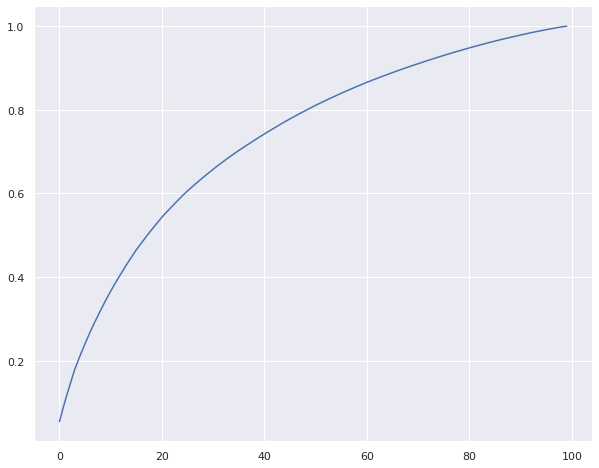

In [54]:
pca = PCA(n_components = 100).fit(vectors)
plt.plot(np.cumsum(pca.explained_variance_ratio_));

In [55]:
pca_vectors = PCA(n_components = 90).fit_transform(vectors)

In [56]:
tsne_vectors = TSNE(
    n_components = 2, 
    n_jobs = 10,
    learning_rate = 200,
    n_iter = 1000,
    n_iter_without_progress = 50
).fit_transform(pca_vectors)

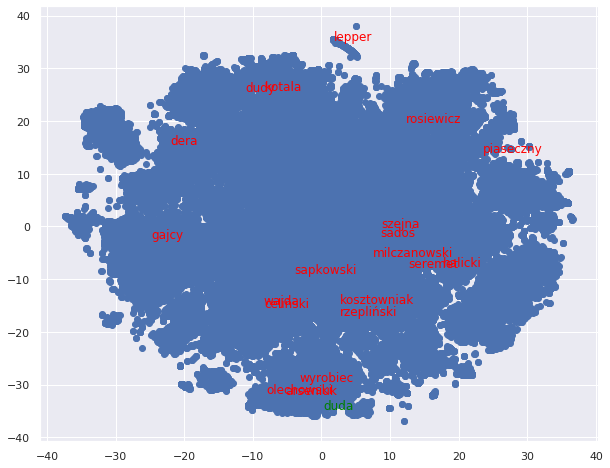

In [59]:
plt.plot(figsize = (12, 12))
plt.scatter(
    [x[0] for x in tsne_vectors],
    [x[1] for x in tsne_vectors],
)
selected_word = 'duda'
idx = list(models['model'].wv.vocab.keys()).index(selected_word)
plt.annotate(selected_word, (tsne_vectors[idx][0], tsne_vectors[idx][1]), color = 'green')
similar_words = [x[0] for x in models['model'].wv.most_similar(positive=[selected_word], topn=20)]
for similar_word in similar_words:
    idx = list(models['model'].wv.vocab.keys()).index(similar_word)
    plt.annotate(similar_word, (tsne_vectors[idx][0], tsne_vectors[idx][1]), color = 'red')